In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold

# ------------------------
# Data Loading & Validation
# ------------------------
try:
    df = pd.read_csv('novice.csv')
    print("Columns in dataset:", df.columns.tolist())
except FileNotFoundError:
    raise SystemExit("Error: File 'novice.csv' not found in current directory.")

# Validate required columns
required_cols = [
    'Stage', 'Match Length', 'Closure Reason',
    'Big Birthdate', 'Little Birthdate',
    'Big Gender', 'Little Gender'
]
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise SystemExit(f"Missing required columns: {missing}")

# ----------------------------
# Survival Data Preparation
# ----------------------------
# Create time-to-event column
df['time'] = df['Match Length']

# Create event indicator (0 = censored/success, 1 = event/failure)
success_conditions = (
    (df['Stage'] == 'Active') |
    (df['time'] >= 24) |
    (df['Closure Reason'].isin(['Child: Graduated', 'Successful Match Closure']))
df['event'] = np.where(success_conditions, 0, 1)

# ----------------------
# Age Difference Feature
# ----------------------
try:
    df['Big Birthdate'] = pd.to_datetime(df['Big Birthdate'], errors='coerce')
    df['Little Birthdate'] = pd.to_datetime(df['Little Birthdate'], errors='coerce')
    
    df['age_diff'] = (
        df['Big Birthdate'].dt.year - 
        df['Little Birthdate'].dt.year
    ).abs()
    
    # Handle missing age differences
    median_age = df['age_diff'].median()
    df['age_diff'] = df['age_diff'].fillna(median_age)
    
except Exception as e:
    raise SystemExit(f"Error calculating age difference: {str(e)}")

# --------------------------
# Feature Engineering
# --------------------------
# 1. Gender Alignment
df['gender_alignment'] = (df['Big Gender'] == df['Little Gender']).astype(int)

# 2. Race Alignment
if 'Big Race' in df.columns and 'Little Race' in df.columns:
    df['race_alignment'] = (df['Big Race'] == df['Little Race']).astype(int)
else:
    print("Warning: Skipping race alignment - columns missing")

# 3. Geographical Alignment (ZIP Code Match)
geo_cols = ['Big ZIP Code', 'Little ZIP Code']
if all(col in df.columns for col in geo_cols):
    df['geo_alignment'] = (df['Big ZIP Code'] == df['Little ZIP Code']).astype(int)
else:
    print("Warning: Skipping geographical alignment - columns missing")

# 4. Program Type Features
if 'Program Type' in df.columns:
    program_dummies = pd.get_dummies(df['Program Type'], prefix='program', drop_first=True)
    df = pd.concat([df, program_dummies], axis=1)
else:
    print("Warning: Skipping program type features - column missing")

# 5. Interest Alignment (Original Implementation)
def calculate_alignment(big_col, little_col):
    def _similarity(row):
        try:
            big = set(str(row[big_col]).split('; ') if pd.notna(row[big_col]) else set()
            little = set(str(row[little_col]).split('; ') if pd.notna(row[little_col]) else set()
            big.discard('None/Other')
            little.discard('None/Other')
            intersection = big.intersection(little)
            union = big.union(little)
            return len(intersection)/len(union) if union else 0
        except:
            return 0
    return _similarity


alignment_features = []
for interest in ['Sports', 'Hobbies']:
    big_col = f'Big Contact: Interest Finder - {interest}'
    little_col = f'Little Contact: Interest Finder - {interest}'
    
    if big_col in df.columns and little_col in df.columns:
        df[f'{interest.lower()}_alignment'] = df.apply(
            calculate_alignment(big_col, little_col), axis=1
        ).fillna(0)
        alignment_features.append(f'{interest.lower()}_alignment')

# --------------------------
#Feature Selection
# --------------------------
#Collect all potential features
all_features = [
    'gender_alignment',
    'age_diff',
    'race_alignment',
    'geo_alignment',
    *alignment_features,
    *[col for col in df.columns if col.startswith('program_')]
]

#Filter features with sufficient variance
analysis_df = df[['time', 'event'] + all_features].dropna()
variances = analysis_df[all_features].var()
valid_features = variances[variances > 0.02].index.tolist()

if not valid_features:
    raise SystemExit("No valid features remaining after variance filtering")

analysis_df = analysis_df[['time', 'event'] + valid_features]

# --------------------------
# Survival Analysis
# --------------------------
def test_penalizers(analysis_df, duration_col='time', event_col='event', 
                   penalizers=None, k_folds=5, plot_results=True):
    """
    Test different penalizers and return optimal model.
    """
    if penalizers is None:
        penalizers = np.logspace(-2, 2, 15)

    results = []
    coef_history = {col: [] for col in valid_features}
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for p in penalizers:
        cph = CoxPHFitter(penalizer=p)
        cv_scores = []
        
        # Cross-validation
        for train_idx, test_idx in kf.split(analysis_df):
            train_df = analysis_df.iloc[train_idx]
            test_df = analysis_df.iloc[test_idx]
            
            cph.fit(train_df, duration_col=duration_col, event_col=event_col)
            partial_hazard = cph.predict_partial_hazard(test_df)
            
            c_score = concordance_index(
                test_df[duration_col],
                -partial_hazard,
                test_df[event_col]
            )
            cv_scores.append(c_score)
        
        mean_cv_score = np.mean(cv_scores)
        
        #Full dataset fit
        cph.fit(analysis_df, duration_col=duration_col, event_col=event_col)
        
        #Store results
        results.append({
            'penalizer': p,
            'mean_c_index': mean_cv_score,
            'train_c_index': cph.concordance_index_,
            'n_coef_nonzero': (np.abs(cph.params_) > 0.01).sum()
        })
        
        #Track coefficients
        for col in valid_features:
            coef_history[col].append(cph.params_.get(col, np.nan))
    
    results_df = pd.DataFrame(results)
    
    if plot_results:
        plt.figure(figsize=(15, 5))
        
        # Performance plot
        plt.subplot(1, 2, 1)
        plt.plot(results_df['penalizer'], results_df['mean_c_index'], 'b-', label='CV Score')
        plt.plot(results_df['penalizer'], results_df['train_c_index'], 'r--', label='Train Score')
        plt.xscale('log')
        plt.xlabel('Penalizer (log scale)')
        plt.ylabel('C-index')
        plt.title('Model Performance vs Penalizer')
        plt.legend()
        
        #Coefficient paths
        plt.subplot(1, 2, 2)
        for col in valid_features:
            plt.plot(results_df['penalizer'], coef_history[col], label=col)
        plt.xscale('log')
        plt.xlabel('Penalizer (log scale)')
        plt.ylabel('Coefficient Value')
        plt.title('Coefficient Paths')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    #Select best penalizer
    best_row = results_df.loc[results_df['mean_c_index'].idxmax()]
    best_penalizer = best_row['penalizer']
    
    print(f"\nOptimal penalizer: {best_penalizer:.4f}")
    print(f"Mean CV C-index: {best_row['mean_c_index']:.4f}")
    print(f"Train C-index: {best_row['train_c_index']:.4f}")
    
    #Fit final model
    final_model = CoxPHFitter(penalizer=best_penalizer)
    final_model.fit(analysis_df, duration_col=duration_col, event_col=event_col)
    
    return results_df, final_model

# --------------------------
#Execute Analysis
# --------------------------
penalizer_results, best_model = test_penalizers(analysis_df)

print("\nFinal Model Summary:")
print("="*50)
print(f"Number of observations: {len(analysis_df)}")
print(f"Number of events: {analysis_df['event'].sum()}")
print("\nTop predictive features:")
print(best_model.summary.sort_values('exp(coef)'))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1927818325.py, line 35)

In [4]:
!pip install pandas


Columns in dataset: ['Match ID 18Char', 'Stage', 'Little ID', 'Big ID', 'Big County', 'Big Age', 'Big Occupation', 'Big: Military', 'Big Approved Date', 'Big Level of Education', 'Big Languages', 'Big Gender', 'Big Birthdate', 'Big Employer', 'Program', 'Program Type', 'Big Race/Ethnicity', 'Closure Reason', 'Closure Details', 'Match Activation Date', 'Match Closure Meeting Date', 'Rationale for Match', 'Big Enrollment: Record Type', 'Big Assessment Uploaded', 'Big Acceptance Date', 'Big Car Access', 'Big Days Acceptance to Match', 'Big Days Interview to Acceptance', 'Big Days Interview to Match', 'Big Open to Cross-Gender Match', 'Big Re-Enroll', 'Big Contact: Preferred Communication Type', 'Big Contact: Former Big/Little', 'Big Contact: Interest Finder - Sports', 'Big Contact: Interest Finder - Places To Go', 'Big Contact: Interest Finder - Hobbies', 'Big Contact: Interest Finder - Entertainment', 'Big Contact: Created Date', 'Big Enrollment: Created Date', 'Big Contact: Volunteer Av

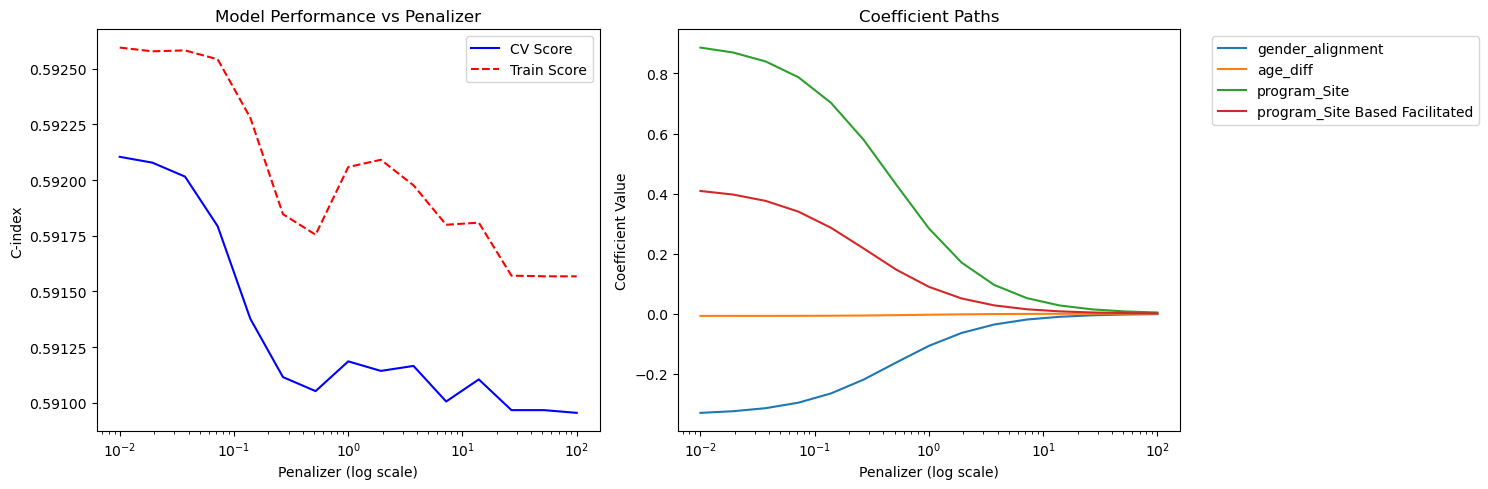


Optimal penalizer: 0.0100
Mean CV C-index: 0.5921
Train C-index: 0.5926

Final Model Summary:
Number of observations: 3275
Number of events: 1300

Top predictive features:
                                    coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                       
gender_alignment               -0.330327   0.718689  0.102685       -0.531586   
age_diff                       -0.007390   0.992638  0.002733       -0.012747   
program_Site Based Facilitated  0.408612   1.504728  0.090702        0.230839   
program_Site                    0.886216   2.425933  0.065267        0.758295   

                                coef upper 95%  exp(coef) lower 95%  \
covariate                                                             
gender_alignment                     -0.129067             0.587672   
age_diff                             -0.002032             0.987334   
program_Site Based Facilitated        0.586385          

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold

# ------------------------
# Data Loading & Validation
# ------------------------
try:
    df = pd.read_csv('novice.csv')
    print("Columns in dataset:", df.columns.tolist())
except FileNotFoundError:
    raise SystemExit("Error: File 'novice.csv' not found in current directory.")

# Validate required columns
required_cols = [
    'Stage', 'Match Length', 'Closure Reason',
    'Big Birthdate', 'Little Birthdate',
    'Big Gender', 'Little Gender'
]
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise SystemExit(f"Missing required columns: {missing}")

# ----------------------------
# Survival Data Preparation
# ----------------------------
#Create time-to-event column
df['time'] = df['Match Length']

# Create event indicator (0 = censored/success, 1 = event/failure)
success_conditions = (
    (df['Stage'] == 'Active') |
    (df['time'] >= 16.8) |
    (df['Closure Reason'].isin(['Child: Graduated', 'Successful Match Closure'])))
df['event'] = np.where(success_conditions, 0, 1)

# ----------------------
#Age Difference Feature
# ----------------------
try:
    df['Big Birthdate'] = pd.to_datetime(df['Big Birthdate'], errors='coerce')
    df['Little Birthdate'] = pd.to_datetime(df['Little Birthdate'], errors='coerce')
    
    df['age_diff'] = (
        df['Big Birthdate'].dt.year - 
        df['Little Birthdate'].dt.year
    ).abs()
    
    # Handle missing age differences
    median_age = df['age_diff'].median()
    df['age_diff'] = df['age_diff'].fillna(median_age)
    
except Exception as e:
    raise SystemExit(f"Error calculating age difference: {str(e)}")

# --------------------------
# Feature Engineering
# --------------------------
# 1. Gender Alignment
df['gender_alignment'] = (df['Big Gender'] == df['Little Gender']).astype(int)

# 2. Race Alignment
if 'Big Race/Ethnicity' in df.columns and 'Little Participant: Race/Ethnicity' in df.columns:
    df['race_alignment'] = (df['Big Race/Ethnicity'] == df['Little Participant: Race/Ethnicity']).astype(int)
else:
    print("Warning: Skipping race alignment - columns missing")

# 3. Geographical Alignment (ZIP Code Match)
geo_cols = ['Big Home Census Block Group', 'Little Mailing Address Census Block Group']
if all(col in df.columns for col in geo_cols):
    df['geo_alignment'] = (df['Big Home Census Block Group'] == df['Little Mailing Address Census Block Group']).astype(int)
else:
    print("Warning: Skipping geographical alignment - columns missing")

# 4. Program Type Features
if 'Program Type' in df.columns:
    program_dummies = pd.get_dummies(df['Program Type'], prefix='program', drop_first=True)
    df = pd.concat([df, program_dummies], axis=1)
else:
    print("Warning: Skipping program type features - column missing")

# 5. Interest Alignment (Original Implementation)
def calculate_alignment(big_col, little_col):
    def _similarity(row):
        try:
            big = set(str(row[big_col]).split('; ') if pd.notna(row[big_col]) else set())
            little = set(str(row[little_col]).split('; ') if pd.notna(row[little_col]) else set())
            big.discard('None/Other')
            little.discard('None/Other')
            intersection = big.intersection(little)
            union = big.union(little)
            return len(intersection)/len(union) if union else 0
        except:
            return 0
    return _similarity

#Create interest alignments
alignment_features = []
for interest in ['Sports', 'Hobbies']:
    big_col = f'Big Contact: Interest Finder - {interest}'
    little_col = f'Little Contact: Interest Finder - {interest}'
    
    if big_col in df.columns and little_col in df.columns:
        df[f'{interest.lower()}_alignment'] = df.apply(
            calculate_alignment(big_col, little_col), axis=1
        ).fillna(0)
        alignment_features.append(f'{interest.lower()}_alignment')


#Feature Selection

#Collect all potential features
all_features = [
    'gender_alignment',
    'age_diff',
    'race_alignment',
    'geo_alignment',
    *alignment_features,
    *[col for col in df.columns if col.startswith('program_')]
]

#Filter features with sufficient variance
analysis_df = df[['time', 'event'] + all_features].dropna()
variances = analysis_df[all_features].var()
valid_features = variances[variances > 0.02].index.tolist()

if not valid_features:
    raise SystemExit("No valid features remaining after variance filtering")

analysis_df = analysis_df[['time', 'event'] + valid_features]

# --------------------------
# Survival Analysis
# --------------------------
def test_penalizers(analysis_df, duration_col='time', event_col='event', 
                   penalizers=None, k_folds=5, plot_results=True):
    """
    Test different penalizers and return optimal model.
    """
    if penalizers is None:
        penalizers = np.logspace(-2, 2, 15)

    results = []
    coef_history = {col: [] for col in valid_features}
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for p in penalizers:
        cph = CoxPHFitter(penalizer=p)
        cv_scores = []
        
        #Cross-validation
        for train_idx, test_idx in kf.split(analysis_df):
            train_df = analysis_df.iloc[train_idx]
            test_df = analysis_df.iloc[test_idx]
            
            cph.fit(train_df, duration_col=duration_col, event_col=event_col)
            partial_hazard = cph.predict_partial_hazard(test_df)
            
            c_score = concordance_index(
                test_df[duration_col],
                -partial_hazard,
                test_df[event_col]
            )
            cv_scores.append(c_score)
        
        mean_cv_score = np.mean(cv_scores)
        
        #Full dataset fit
        cph.fit(analysis_df, duration_col=duration_col, event_col=event_col)
        
        results.append({
            'penalizer': p,
            'mean_c_index': mean_cv_score,
            'train_c_index': cph.concordance_index_,
            'n_coef_nonzero': (np.abs(cph.params_) > 0.01).sum()
        })
        
        #Track coefficients
        for col in valid_features:
            coef_history[col].append(cph.params_.get(col, np.nan))
    
    results_df = pd.DataFrame(results)
    
    if plot_results:
        plt.figure(figsize=(15, 5))
        
        #Performance plot
        plt.subplot(1, 2, 1)
        plt.plot(results_df['penalizer'], results_df['mean_c_index'], 'b-', label='CV Score')
        plt.plot(results_df['penalizer'], results_df['train_c_index'], 'r--', label='Train Score')
        plt.xscale('log')
        plt.xlabel('Penalizer (log scale)')
        plt.ylabel('C-index')
        plt.title('Model Performance vs Penalizer')
        plt.legend()
        
        #Coefficient paths
        plt.subplot(1, 2, 2)
        for col in valid_features:
            plt.plot(results_df['penalizer'], coef_history[col], label=col)
        plt.xscale('log')
        plt.xlabel('Penalizer (log scale)')
        plt.ylabel('Coefficient Value')
        plt.title('Coefficient Paths')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    #Select best penalizer
    best_row = results_df.loc[results_df['mean_c_index'].idxmax()]
    best_penalizer = best_row['penalizer']
    
    print(f"\nOptimal penalizer: {best_penalizer:.4f}")
    print(f"Mean CV C-index: {best_row['mean_c_index']:.4f}")
    print(f"Train C-index: {best_row['train_c_index']:.4f}")
    
    #Fit final model
    final_model = CoxPHFitter(penalizer=best_penalizer)
    final_model.fit(analysis_df, duration_col=duration_col, event_col=event_col)
    
    return results_df, final_model

# --------------------------
#Analysis
# --------------------------
penalizer_results, best_model = test_penalizers(analysis_df)

print("\nFinal Model Summary:")
print("="*50)
print(f"Number of observations: {len(analysis_df)}")
print(f"Number of events: {analysis_df['event'].sum()}")
print("\nTop predictive features:")
print(best_model.summary.sort_values('exp(coef)'))